In [1]:
import mdtraj as md
import numpy as np
from pymol import cmd
from pymol import stored
import matplotlib.pyplot as plt
import itertools
import warnings
import multiprocessing
from tqdm import tqdm
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
import pickle
import pandas as pd
import glob

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
os.environ["CUDA_VISIBLE_DEVICES"]="3"


In [3]:
def save_pocket(pdb, sdf, name):
    cmd.reinitialize()
    cmd.load(pdb)
    cmd.load(sdf, "LIG")
    cmd.select("POCK","br. LIG around 4")
    stored.idx = 0
    cmd.iterate("POCK and n. CA", expression="stored.idx+=1")
    cmd.save(name, "POCK")
    return stored.idx

In [5]:
# dict_aa = {'CYS': 0, 'ASP': 1, 'SER': 2, 'GLN': 3, 'LYS': 4,
#      'ILE': 5, 'PRO': 6, 'THR': 7, 'PHE': 8, 'ASN': 9, 
#      'GLY': 10, 'HIS': 11, 'LEU': 12, 'ARG': 13, 'TRP': 14, 
#      'ALA': 15, 'VAL':16, 'GLU': 17, 'TYR': 18, 'MET': 19}

# dict_element = {"H": 20, "I":21,
#        "N": 22,
#        "P":23,
#        "C": 24,
#        "O":25,
#        "F": 26,
#        "S": 27,
#        "Li": 28,
#        "Cl": 29,
#        "Br": 30}

aa_hscale = {
"ALA":  0.620,
"ARG": -2.530,
"ASN": -0.780,
"ASP": -0.900,
"CYS":  0.290,
"GLN": -0.850,
"GLU": -0.740,
"GLY":  0.480,
"HIS": -0.400,
"ILE":  1.380,
"LEU":  1.060,
"LYS": -1.500,
"MET":  0.640,
"PHE":  1.190,
"PRO":  0.120,
"SER": -0.180,
"THR": -0.050,
"TRP":  0.810,
"TYR":  0.260,
"VAL":  1.080}

element_charge = {"H": +1, "I":-1,
           "N": -3,
           "P":-3,
           "C": +4,
           "O":-2,
           "F": -1,
           "S": -2,
           "Li": +1,
           "Cl": -1,
           "Br": -1}

In [8]:
# convert files into list of strings
# for the protein pdb and ligand sdf 
# (states are separated by $$$$)
def stringify(sdf, pdb, num_states):
    sdf_split = []
    with open(sdf,'r') as f:
        for key,group in itertools.groupby(f,lambda line: line.startswith('$$$$')):
          if not key:
            sdf_split.append("".join(list(group)))
          if len(sdf_split) == num_states:
            break
    with open(pdb,'r') as f:
        pdb_string = f.readlines()       
    return sdf_split, "".join(pdb_string)


def create_pdb(sdf, pdb_string,i):
    lines = sdf.split('\n')
    num_lines = (int)(lines[3].split(' ')[1])
    lig = lines[4:4+num_lines-1]
    lig = list(filter(lambda x: 'H' not in x, lig))
    lig_pdb = list(map(create_line, lig, np.arange(1,len(lig)+1)))
    f =  open("tmp{0}.pdb".format(i), 'w+')
    f.write("\n".join(lig_pdb))
    f.write("\n")
    f.write(pdb_string)
    f.close()

# Create one line in the new pdb file for one state
# and the protein
# Use the standardized pdb regex to create the correct string
def create_line(line,i):
    split = line.split(' ')
    split = list(filter(lambda x: x != '', split))
    vals1 = (float)(split[0])
    vals2 = (float)(split[1])
    vals3= (float)(split[2]) 
    atom = split[3]

    # workaround to get the atoms in the ligand to be residues in mdtraj reader
    if i >=10 :
        new_string = "{:6s}{:5d} {:^4s}{:1s}{:3s} {:1s}{:4d}{:1s}   {:8.3f}{:8.3f}{:8.3f}{:6.2f}{:6.2f}          {:>2s}{:2s}".format("HETATM",i,atom,'',"U"+str(i),'',0,'',vals1, vals2,vals3,0,0,atom,'')
    else:
        new_string = "{:6s}{:5d} {:^4s}{:1s}{:3s} {:1s}{:4d}{:1s}   {:8.3f}{:8.3f}{:8.3f}{:6.2f}{:6.2f}          {:>2s}{:2s}".format("HETATM",i,atom,'',"UN"+str(i),'',0,'',vals1, vals2,vals3,0,0,atom,'')
    return new_string

# Create the data for ML model

# First array is contact matrix
# - ----------------| ligand atoms | protein residues
# - ligand atoms    |              | 
# ------------------|--------------|-----------------
# - protein residues|              |
#
# Second array is a mask for which cells correspond to ligand x ligand (-1), 
# protein x protein (1) and ligand x protein (0)
#
# Arrays are interpolated to 80x80
def maker_w_strings(data):
    i,sdf_state, num_residues, pdb = data
    tmp_file = str(id(multiprocessing.current_process()))
    create_pdb(sdf_state,pdb,tmp_file) # create the pdb for one states
    
    # Load the file into mdtraj
    t = md.load("tmp{0}.pdb".format(tmp_file))
    pl = len(list(t.topology.residues))
    resi = np.arange(pl)
    pairs = list(itertools.product(resi, resi))
    
    # compute constacts
    matrix, l = md.compute_contacts(t, contacts=pairs, scheme="closest-heavy")
    matrix = np.array(matrix).reshape((pl,pl))
    
    aa_matrix_h = np.zeros((pl, pl))
    aa_matrix_v = np.zeros((pl, pl))
    resi_list = list(t.topology.residues)
    atom_list = list(t.topology.atoms)

    for p in range(pl):
        r = resi_list[p]
        if not str(r).startswith('U'):
            aa_matrix_v[:,p]=aa_hscale[r.name]
            aa_matrix_h[p]=aa_hscale[r.name]
        else:
            a = atom_list[p]
            aa_matrix_v[:,p] =element_charge[a.name]
            aa_matrix_h[p]=element_charge[a.name]
            
    ### generate protein-ligand mask
    mask = np.zeros((pl,pl))
    for i in range(pl-num_residues):
        for j in range(pl-num_residues):
            # ligand
            mask[i,j] = -1
            
    for i in range(pl - num_residues,pl):
        for j in range( pl - num_residues,pl):
            # protein
            mask[i,j] = 1
            
    p_img = cv2.resize(matrix, dsize=(64, 64), interpolation=cv2.INTER_CUBIC).reshape(64,64,1)
    m_img = cv2.resize(mask, dsize=(64, 64), interpolation=cv2.INTER_CUBIC).reshape(64,64,1)
    v_img = cv2.resize(aa_matrix_v, dsize=(64, 64), interpolation=cv2.INTER_CUBIC).reshape(64,64,1)
    h_img = cv2.resize(aa_matrix_h, dsize=(64, 64), interpolation=cv2.INTER_CUBIC).reshape(64,64,1)

    p_contact_matrix = np.concatenate([p_img, m_img, v_img, h_img], axis=-1)
    os.remove("tmp{0}.pdb".format(tmp_file))
    return p_contact_matrix
    

In [9]:
maps=[]
num_residues = save_pocket("adrp_adpr/ADRP_6W02_A_1_H.pdb", "adrp_adpr/adrp_adpr_A_cat_sorted_top100.sdf", "adrp_adpr/adrp_gen_pocket.pdb")
print("done creating pocket")
s, pdb_string = stringify("adrp_adpr/adrp_adpr_A_cat_sorted.sdf", "adrp_adpr/adrp_gen_pocket.pdb", 10000)
pdb_string = [pdb_string for x in range(len(s))]

with multiprocessing.Pool(32) as p:
    num_states = len(s)
    data = list(zip(range(num_states), s, num_residues*np.ones(num_states,dtype=int), pdb_string))
    itern = p.imap(maker_w_strings, data)
    for i,p_contact_matrix in enumerate(tqdm(itern, total=num_states)):
        maps.append(p_contact_matrix)


done creating pocket


100%|██████████| 10000/10000 [00:53<00:00, 187.19it/s]


In [10]:
images_100k = np.stack(maps,axis=0)
print(images_100k.shape)

(10000, 64, 64, 4)


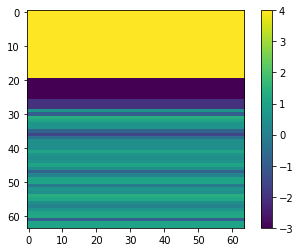

In [13]:
plt.imshow(maps[0][:,:,3])
plt.colorbar()

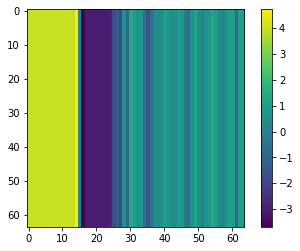

In [27]:
plt.imshow(maps[10][:,:,2])
plt.colorbar()

In [14]:
scores = pd.read_csv("adrp_adpr/adrp_adpr_A_cat_sorted.csv")["Chemgauss4"]
scores = np.clip(-100, 0, scores)
scores = np.abs(scores.to_numpy())
scaler = MinMaxScaler()
scaled_scores = scaler.fit_transform(scores.reshape(-1,1))

In [53]:
data_images =[]
data_scores = []
files_m = glob.glob('./**/*.matrices.npy', recursive=True)
files_s = glob.glob('./**/*.scores.npy', recursive=True)
for m,s in zip(files_m, files_s):
    print(m,s)
    data_images.append(np.load(m)[0:5000])
    data_scores.append(np.load(s)[0:5000])

./april27/PLPro/2/PLPRO_2_cat_sorted.matrices.npy ./april27/PLPro/2/PLPRO_2_cat_sorted.scores.npy
./april27/PLPro/1/plpro_1_cat_sorted.matrices.npy ./april27/PLPro/1/plpro_1_cat_sorted.scores.npy
./april27/NSP15_6w01/2/NSP15_2_6w01_cat_sorted.matrices.npy ./april27/NSP15_6w01/2/NSP15_2_6w01_cat_sorted.scores.npy
./april27/NSP15_6w01/1/NSP15_1_6w01_cat_sorted.matrices.npy ./april27/NSP15_6w01/1/NSP15_1_6w01_cat_sorted.scores.npy
./april27/NSP15_6vww/1/NSP15_1_6vww_cat_sorted.matrices.npy ./april27/NSP15_6vww/1/NSP15_1_6vww_cat_sorted.scores.npy
./april27/NSP15_6vww/2/NSP15_2_6vww_cat_sorted.matrices.npy ./april27/NSP15_6vww/2/NSP15_2_6vww_cat_sorted.scores.npy
./april27/3CLPro/1/3CLPro_1_cat_sorted.matrices.npy ./april27/3CLPro/1/3CLPro_1_cat_sorted.scores.npy
./april27/3CLPro/2/3CLPro_2_cat_sorted.matrices.npy ./april27/3CLPro/2/3CLPro_2_cat_sorted.scores.npy
./april27/3CLPro/3/3CLPro_3_cat_sorted.matrices.npy ./april27/3CLPro/3/3CLPro_3_cat_sorted.scores.npy
./april27/ADRP/adrp_adpr_A

In [54]:
X = np.vstack(data_images)
y = np.hstack(data_scores)
# X = np.stack(maps,axis=0)
print(X.shape)

(60000, 64, 64, 4)


In [55]:
scaler = MinMaxScaler()
y = np.clip(-100, 0, y)
y = np.abs(y)
y_scaled = scaler.fit_transform(y.reshape(-1,1))

In [56]:
print(X.shape, y_scaled.shape)

(60000, 64, 64, 4) (60000, 1)


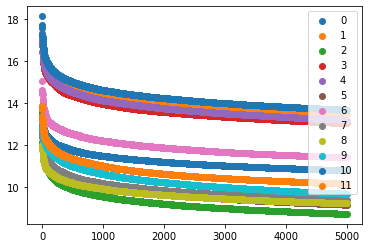

In [57]:
for i in range(12):
    plt.scatter(np.arange(5000), y[5000*i:5000*(i+1)], label=i)
plt.legend()    

(60000, 64, 64, 2)


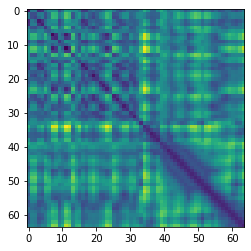

In [58]:
X_2d = X[:,:,:,0:2]
print(X_2d.shape)
plt.imshow(X_2d[0][:,:,0])

In [59]:
X_bg = np.vstack((X_2d[0:10000], X_2d[20000:30000]))
y_bg = np.vstack((y_scaled[0:10000], y_scaled[20000:30000]))
print(X_bg.shape, y_bg.shape)
X_ro = np.vstack((X_2d[10000:20000], X_2d[30000:40000]))
y_ro = np.vstack((y_scaled[10000:20000], y_scaled[30000:40000]))
X_1 = X_2d[0:10000]
y_1 = y_scaled[0:10000]

(20000, 64, 64, 2) (20000, 1)


In [93]:
# X_train, X_test, y_train, y_test = train_test_split(X_set,y_set, test_size=0.25,
#                                                      shuffle=True)
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X, y_scaled, test_size=0.25,
                                                     shuffle=True)

In [94]:
# X_train_3d = np.array([ np.concatenate((X_train_top[i],np.expand_dims(X_train_top[i][:,:,0], axis=-1)), axis=-1) for i in range(X_train_top.shape[0])])
# print(X_train_3d.shape)
# X_test_3d = np.array([ np.concatenate((X_test_top[i],np.expand_dims(X_test_top[i][:,:,0], axis=-1)), axis=-1) for i in range(X_test_top.shape[0])])
# print(X_test_3d.shape)

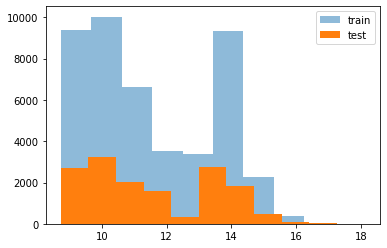

In [95]:
plt.hist(scaler.inverse_transform(y_train_top), alpha=0.5, label='train')
plt.hist(scaler.inverse_transform(y_test_top),alpha=1, label='test')
#plt.hist(scores,alpha=0.25, label='100k scores')
plt.legend()

In [96]:
def adapt_learning_rate(epoch):
    return 1e-3 * epoch
my_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate)

In [97]:
def r2_keras(y_true, y_pred):
    from tensorflow.keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [98]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# # applying transformation to image
# train_gen = ImageDataGenerator(rotation_range=180)
# test_gen = ImageDataGenerator()
# training_set= train_gen.flow(X_train_3d, y_train_top, batch_size=64)
# test_set= train_gen.flow(X_test_3d, y_test_top, batch_size=64)

In [99]:
dr = 0.25
model = Sequential()
model.add(Conv2D(8, kernel_size=(6, 6),
                 activation='relu',
                 input_shape=(64,64,4)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dr))
model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(dr))
model.add(Dense(64, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(64, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(1))

model.compile(loss=tf.keras.losses.mean_squared_error,
              optimizer=tf.keras.optimizers.Adam(lr=5e-5),
              metrics=['mean_squared_error', r2_keras])
print(model.summary())
history = model.fit(X_train_top, y_train_top,
          batch_size=64,
          epochs=50,
          verbose=1,
          validation_data=(X_test_top, y_test_top))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 59, 59, 8)         1160      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 57, 57, 32)        2336      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 55, 55, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 27, 27, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 27, 27, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 23328)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)               

Epoch 31/50
45000/45000 [==============================] - 6s 142us/sample - loss: 0.0033 - mean_squared_error: 0.0033 - r2_keras: 0.9178 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_r2_keras: 0.9237
Epoch 32/50
45000/45000 [==============================] - 6s 144us/sample - loss: 0.0032 - mean_squared_error: 0.0032 - r2_keras: 0.9194 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_r2_keras: 0.9225
Epoch 33/50
45000/45000 [==============================] - 6s 142us/sample - loss: 0.0032 - mean_squared_error: 0.0032 - r2_keras: 0.9193 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_r2_keras: 0.9218
Epoch 34/50
45000/45000 [==============================] - 7s 145us/sample - loss: 0.0032 - mean_squared_error: 0.0032 - r2_keras: 0.9194 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_r2_keras: 0.9214
Epoch 35/50
45000/45000 [==============================] - 6s 144us/sample - loss: 0.0032 - mean_squared_error: 0.0032 - r2_keras: 0.9192 - val_loss

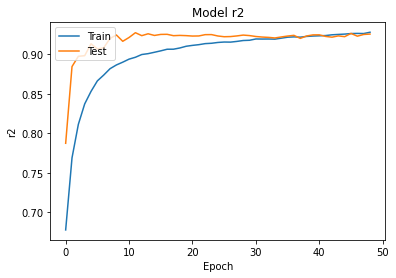

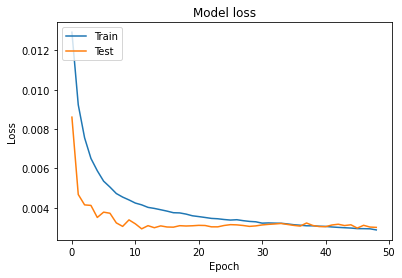

In [100]:
# Plot training & validation loss values
plt.plot(history.history['r2_keras'][1:])
plt.plot(history.history['val_r2_keras'][1:])
plt.title('Model r2')
plt.ylabel('r2')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')

plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [101]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test_top)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test_top)
y_train_inv = scaler.inverse_transform(y_train_top)

print(r2_score(y_test_inv, y_pred_inv))
print(y_pred)
print(y_test_top)

0.9268537253593039
[[0.33862436]
 [0.5295774 ]
 [0.1288377 ]
 ...
 [0.1635359 ]
 [0.13770588]
 [0.5904736 ]]
[[0.32244124]
 [0.53146589]
 [0.07899032]
 ...
 [0.12600478]
 [0.12350506]
 [0.61976265]]


In [102]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
print(pearsonr(y_test_inv.flatten(),y_pred_inv.flatten()))
print(spearmanr(y_test_inv.flatten(),y_pred_inv.flatten()))

(0.9643410203177675, 0.0)
SpearmanrResult(correlation=0.937164039152786, pvalue=0.0)


In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_squared_error(y_test_top, y_pred))
print(mean_squared_error(y_test_inv, y_pred_inv))

0.0030106253742175778
0.2665995432130245


In [104]:
print(min(y_test_inv), max(y_test_inv))

[8.725832] [17.258532]


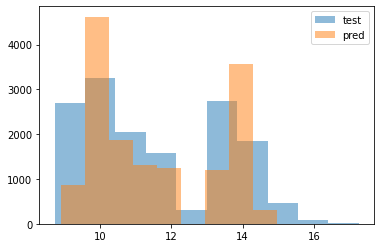

In [105]:
#plt.hist(y_train_inv)
#plt.show()
plt.hist(y_test_inv, alpha=0.5, label="test")
#plt.show()
plt.hist(y_pred_inv,alpha=0.5, label="pred")
plt.legend()
plt.show()

In [68]:
os.path.splitext("a/b/c.txt")

('a/b/c', '.txt')